<a href="https://colab.research.google.com/github/OUCHAOUA/Unsupervased-Cluster/blob/master/Unsupervased_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K-means & clustering hiérarchique 
Ce cas nécessite de développer une segmentation client pour définir la stratégie marketing. L'exemple de jeu de données résume le comportement d'utilisation d'environ 9 000 titulaires de carte de crédit actifs au cours des 6 derniers mois. Le fichier est au niveau du client avec 18 variables comportementales.

Voici le dictionnaire de données pour l' ensemble de données des cartes de crédit :
CUST_ID: Identification du titulaire de la carte de crédit (catégorique)
BALANCE:  montant du solde restant sur leur compte pour effectuer des achats 
BALANCE_FREQUENCY: fréquence de mise à jour du solde, score compris entre 0 et 1 (1 = fréquemment mis à jour, 0 = pas fréquemment mis à jour) 
ACHATS: Montant des achats effectués à partir du compte 
ONEOFF_PURCHASES: montant maximum d'achat effectué en une seule fois
INSTALLMENTS_PURCHASES:  Montant de l'achat effectué en plusieurs fois
CASH_ADVANCE:  Paiement d'avance donné par l'utilisateur
PURCHASES_FREQUENCY: à quelle fréquence les achats sont effectués, score entre 0 et 1 (1 = fréquemment acheté, 0 = pas souvent acheté)
ONEOFFPURCHASESFREQUENCY: Fréquence  des achats en une seule fois (1 = fréquemment acheté, 0 = pas fréquemment acheté)
PURCHASESINSTALLMENTSFREQUENCY:  Fréquence des achats échelonnés (1 = fréquemment effectué, 0 = pas fréquemment effectué)
CASHADVANCEFREQUENCY : Fréquence de paiement de l'avance en espèces 
CASHADVANCETRX : Nombre de transactions effectuées avec "Cash in Advanced"
PURCHASES_TRX : Nombre de transactions d'achat en
CREDIT_LIMIT : limite de carte de crédit pour l'utilisateur 
PAYMENTS: Montant du paiement effectué par l'utilisateur
MINIMUM_PAYMENTS: Montant minimum des paiements effectués par l'utilisateur
PRCFULLPAYMENT: Pourcentage du paiement intégral payé par l'utilisateur
TENURE: Durée du service de carte de crédit pour l'utilisateur


1. Chargez votre jeu de données. 

2. Utilisez le clustering hiérarchique pour identifier les regroupements inhérents à vos données.

3. Tracez les grappes. 

4. Tracez le dendrogramme. Utilisez le clustering k-means. 

5. Essayez différentes valeurs de k et sélectionnez la meilleure. 

6. Tracez les grappes. 

7. Comparez les deux résultats. 

Bonus: recherchez une autre métrique de validation

In [ ]:
import pandas as pd
from google.colab import files
data_to_load = files.upload()

import io
data = pd.read_csv(io.BytesIO(data_to_load['CC GENERAL.csv']))
data

Saving CC GENERAL.csv to CC GENERAL (5).csv


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [ ]:
data = data.drop("CUST_ID", axis=1)

In [ ]:
data.shape

(8950, 17)

In [ ]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS       313
CREDIT_LIMIT             1
TENURE                   0
PURCHASES_FREQUENCY      0
BALANCE_FREQUENCY        0
dtype: int64

In [ ]:
# NAN
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean( )
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

In [ ]:
for col in data.columns:
    print('{:40} : {:10} : {:}'.format(col, data[col].nunique(), data[col].dtype))

BALANCE                                  :       8871 : float64
BALANCE_FREQUENCY                        :         43 : float64
PURCHASES                                :       6203 : float64
ONEOFF_PURCHASES                         :       4014 : float64
INSTALLMENTS_PURCHASES                   :       4452 : float64
CASH_ADVANCE                             :       4323 : float64
PURCHASES_FREQUENCY                      :         47 : float64
ONEOFF_PURCHASES_FREQUENCY               :         47 : float64
PURCHASES_INSTALLMENTS_FREQUENCY         :         47 : float64
CASH_ADVANCE_FREQUENCY                   :         54 : float64
CASH_ADVANCE_TRX                         :         65 : int64
PURCHASES_TRX                            :        173 : int64
CREDIT_LIMIT                             :        206 : float64
PAYMENTS                                 :       8711 : float64
MINIMUM_PAYMENTS                         :       8637 : float64
PRC_FULL_PAYMENT                         :  

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.pyplot as plt

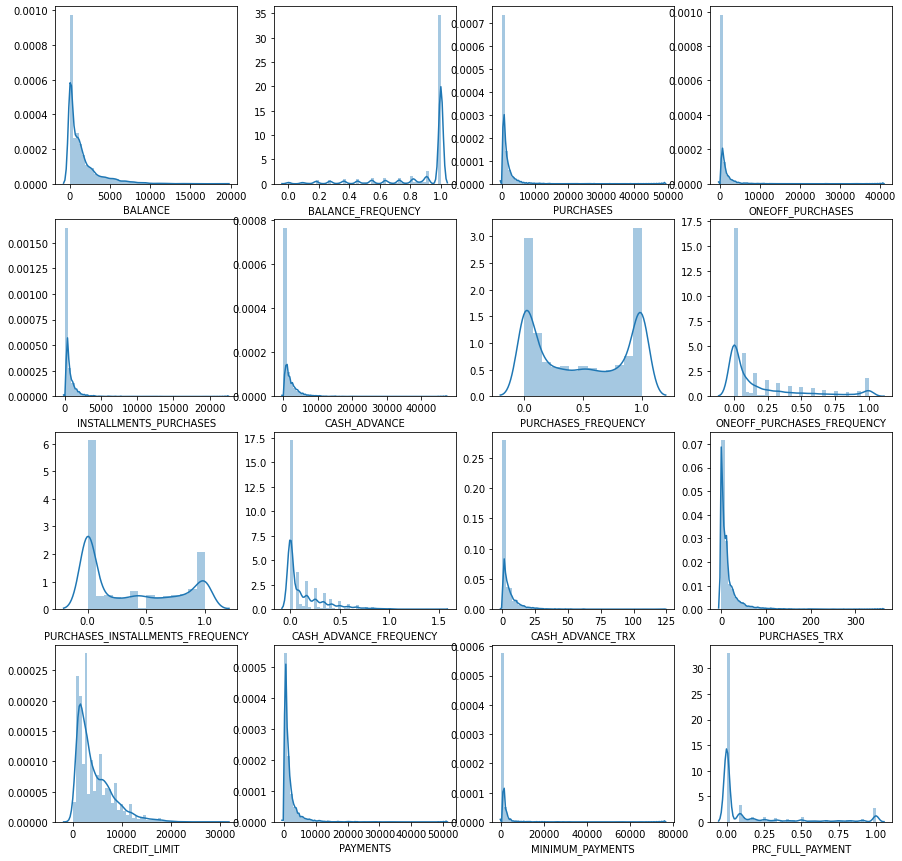

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
col = 0
for i in range(4): 
    for j in range(4):
        sns.distplot(data[data.columns[col]], ax=axs[i,j])
        col +=1
plt.show()

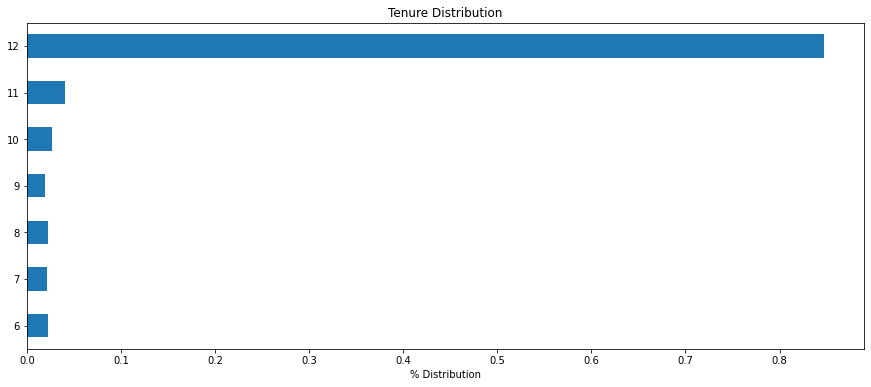

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
(data['TENURE'].value_counts().sort_index()/len(data)).plot(kind='barh')
plt.title('Tenure Distribution')
plt.xlabel('% Distribution');

In [ ]:
del fig, axs

In [ ]:
from sklearn.cluster import AgglomerativeClustering 

model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')

clust_labels=model.fit_predict(data)

In [30]:
import numpy as np
agglomerative = pd.DataFrame(clust_labels)
agglomerative.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921,8922,8923,8924,8925,8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


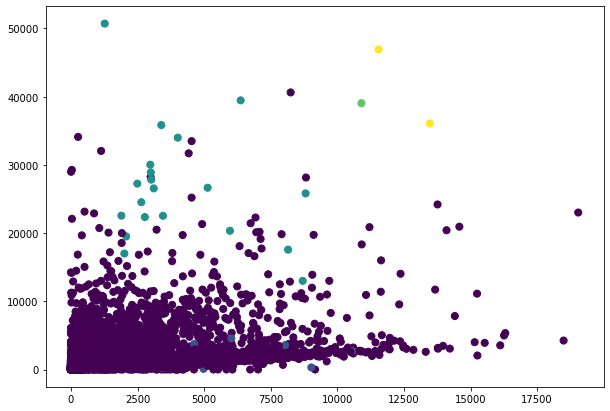

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter (data ['BALANCE'] , data ['PAYMENTS'] , c= agglomerative[0], s=50)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
X = np.asarray(data)
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

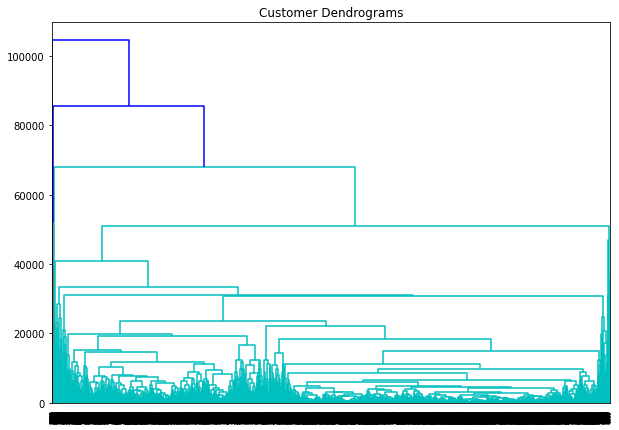

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10,7))
plt.title("Customer Dendrograms")
den = shc.dendrogram(shc.linkage(data, method="complete"))

In [ ]:
from sklearn.cluster import KMeans 

k_range = range(1,30)
cost=[]
for k in k_range:
    kmean= KMeans(k)
    kmean.fit(X)
    cost.append(kmean.inertia_) 

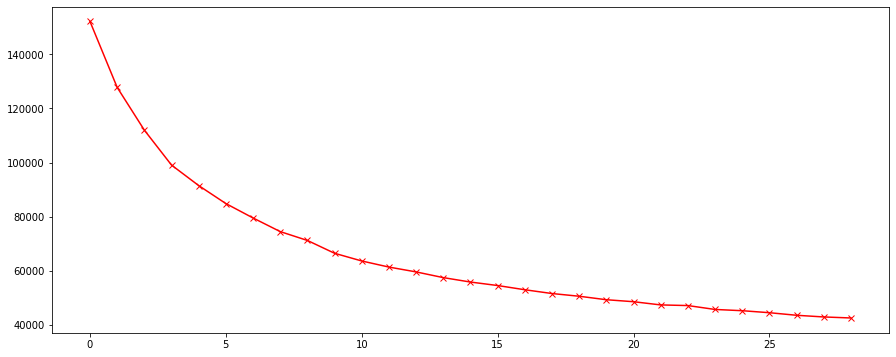

In [31]:
plt.figure(figsize=(15,6))    
plt.plot(cost, 'rx-')

In [ ]:
kmean= KMeans(6)
kmean.fit(X)
cluster=kmean.labels_ + 1

In [ ]:
clusters=pd.concat([data, pd.DataFrame({'cluster':cluster})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,4
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,4
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,4


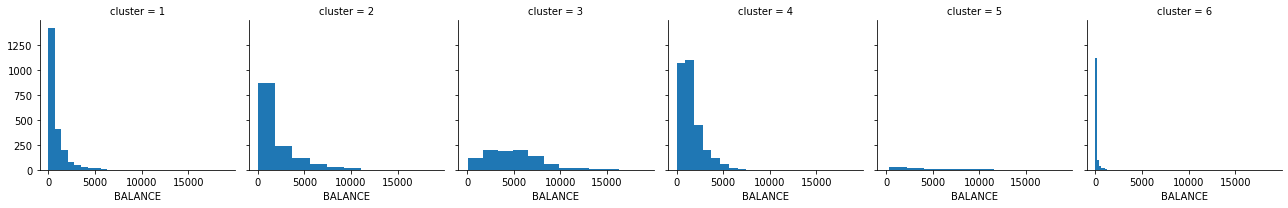

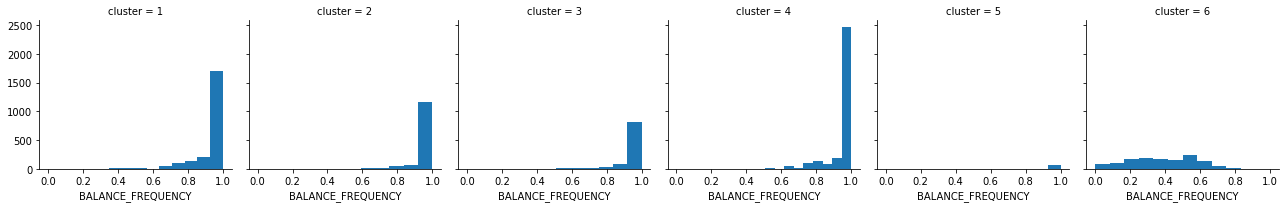

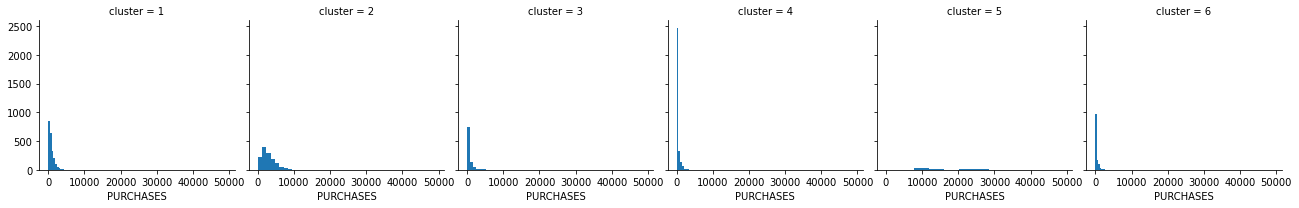

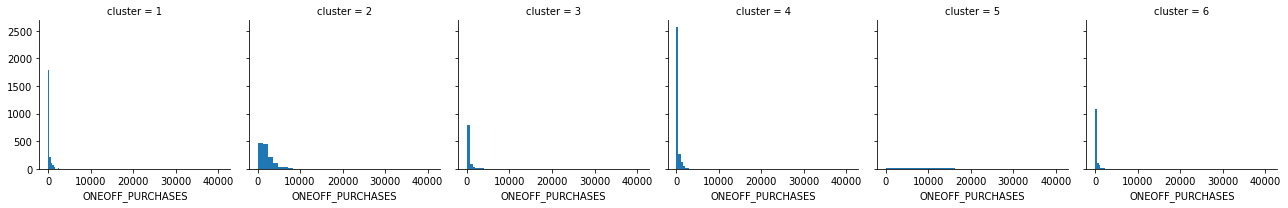

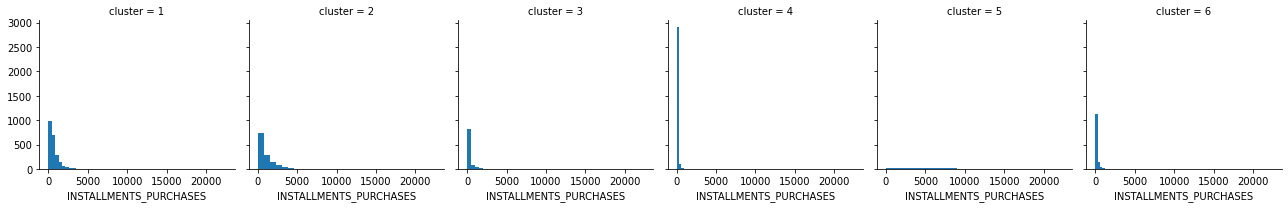

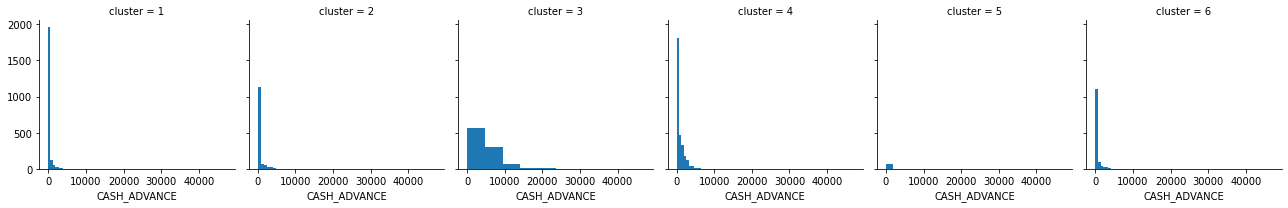

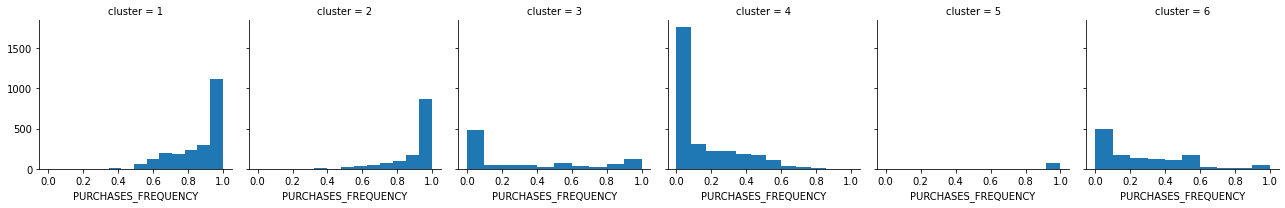

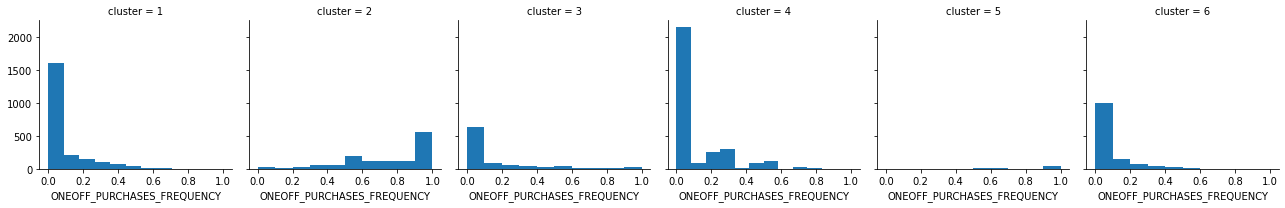

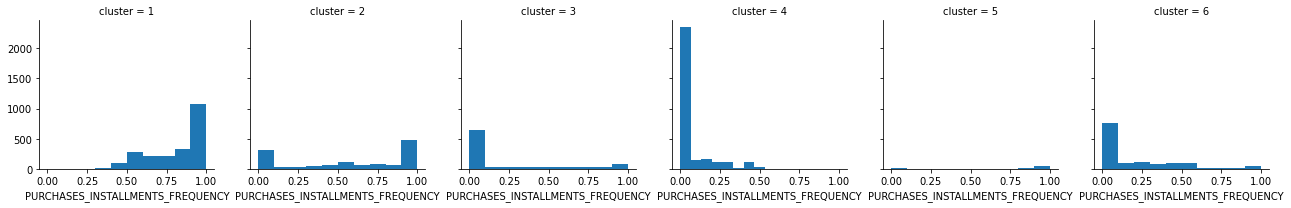

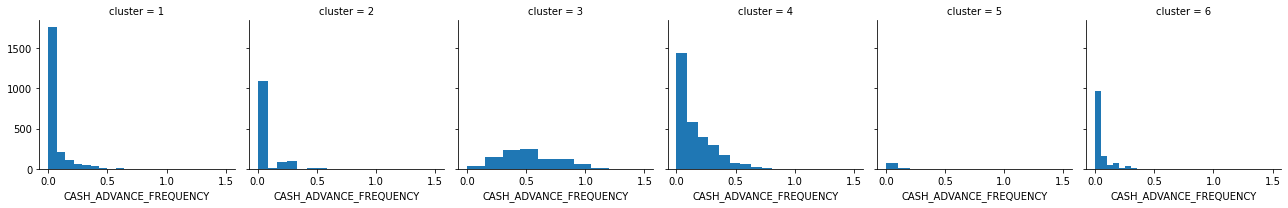

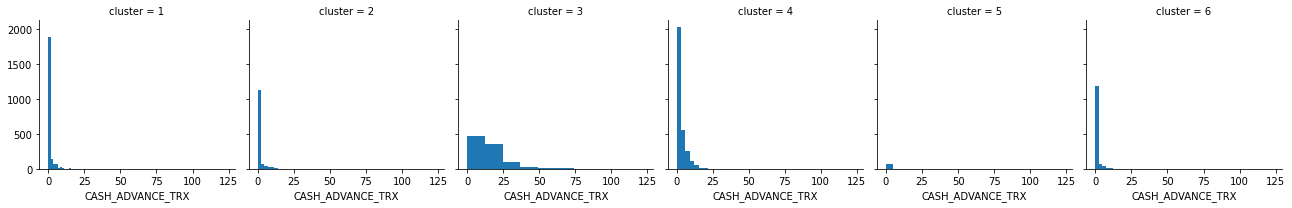

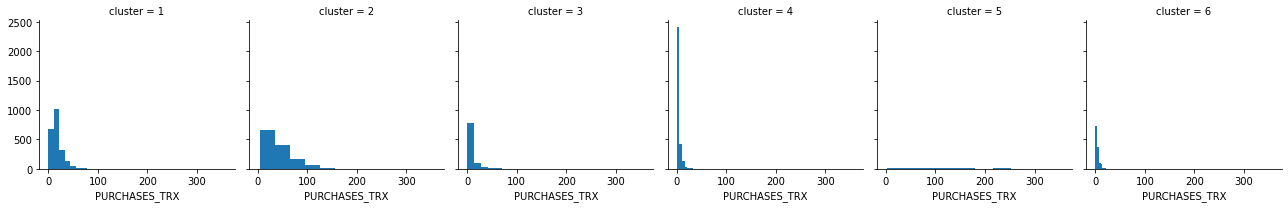

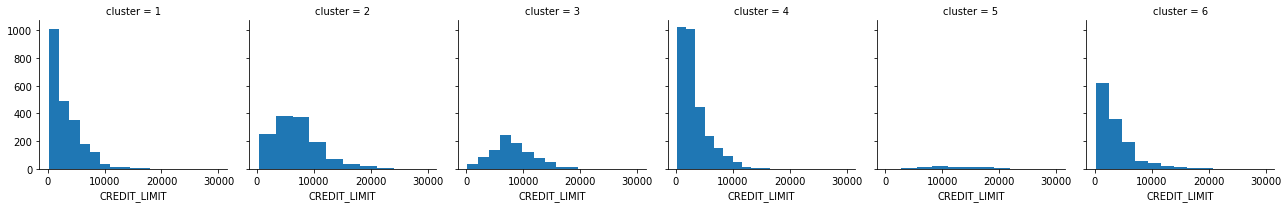

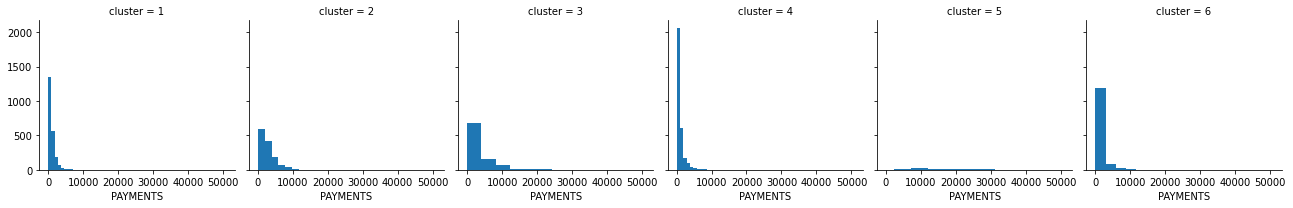

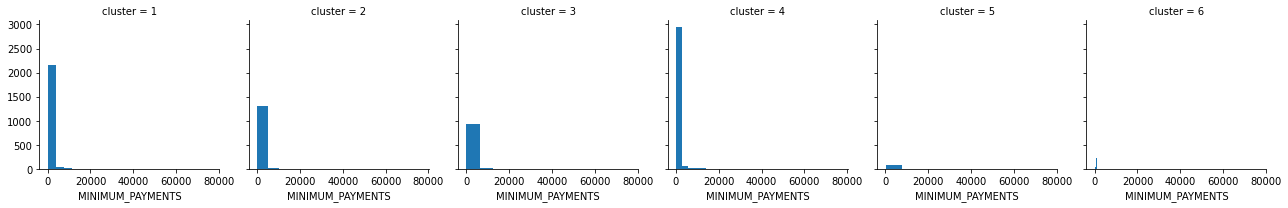

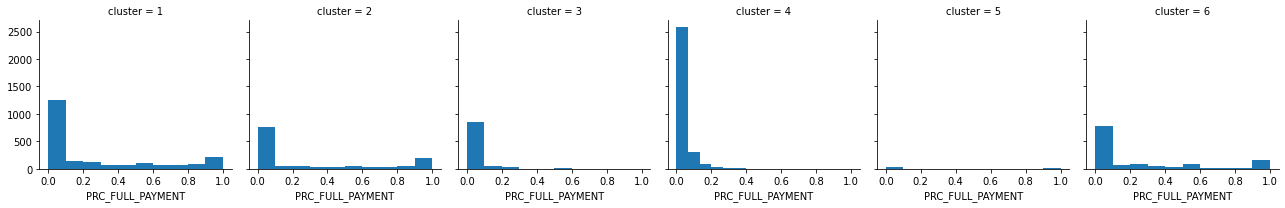

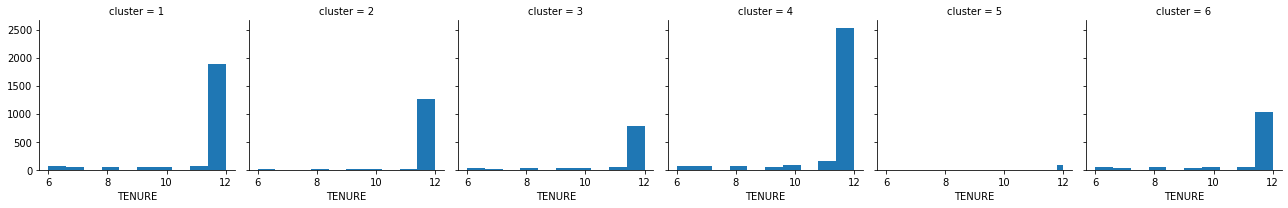

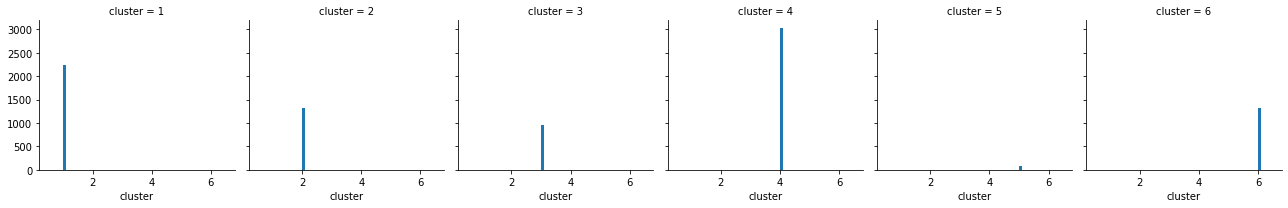

In [ ]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import PCA

In [ ]:
dist = 1 - cosine_similarity(X)

pca = PCA(3)
pca.fit(dist)
X_PCA = pca.transform(dist)

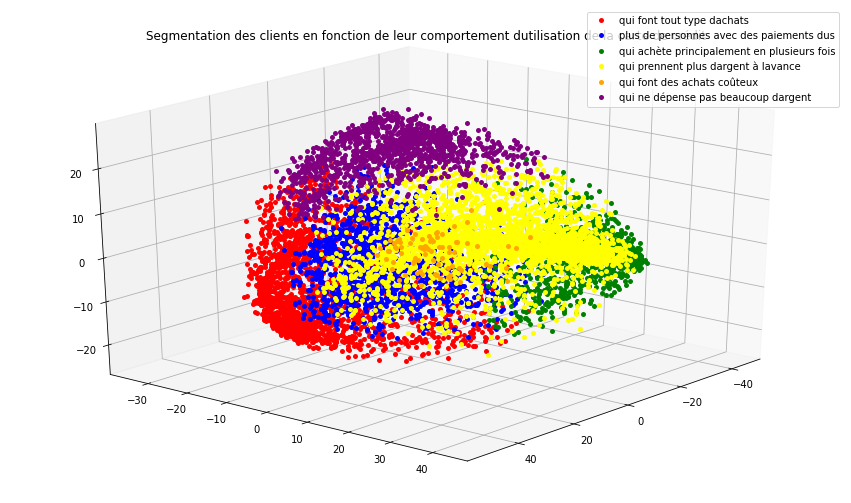

In [33]:
x, y, z = X_PCA[:, 0], X_PCA[:, 1], X_PCA[:, 2]

colors = {1: 'red',
          2: 'blue',
          3: 'green', 
          4: 'yellow', 
          5: 'orange',  
          6: 'purple'}

names = {1: 'qui font tout type d''achats',
         2: 'plus de personnes avec des paiements dus',
         3: 'qui achète principalement en plusieurs fois',
         4: 'qui prennent plus d''argent à l''avance' ,
         5: 'qui font des achats coûteux',
         6: 'qui ne dépense pas beaucoup d''argent'}
  
df = pd.DataFrame({'x': x, 'y':y, 'z':z,'label':cluster}) 
groups = df.groupby('label')

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

for name, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')


ax.view_init(25, 40)
ax.legend()
ax.set_title('Segmentation des clients en fonction de leur comportement d''utilisation de la carte de crédit')
plt.show()